# View coadds generated by `ImageSampler`

This notebook is for getting a sense of what simulated images look like, and as a first checkpoint for testing the behavior of new artifacts.

## Imports

In [51]:
# for reloading changes made in break_coadd_sbi
%load_ext autoreload
%autoreload 2

# setup torch for use with a CPU
# since this notebook is not intended for training a model
import os
os.environ['CUDA_VISIBLE_DEVICES']=""

import torch
torch.set_num_threads(8)

# typical data analysis imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pickle

matplotlib.rcParams['figure.dpi']=(150) # for consistent figures

# local imports
from break_coadd_sbi import catsampler
from break_coadd_sbi import imagesampler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Default Coadds

Simulate star catalogs using `catsampler`, then model coadds with all default values in `imagesampler`. I'm starting with very basic models to get a sense of the modeling workflow.

In [2]:
# define the model for the star catalog
prior_catalog = catsampler.TwoStarCatalogSimulator(
    center = (20.0,40.0),
)

# define the model for the coadd simulation
default_image_model = imagesampler.ImageSampler(
    coadd_depth=5,
    height = 40,
    width = 80,
    translation_artifacts=False,
)

In [3]:
# use a random generator to pull realizations of the models defined above
rng=torch.Generator(device='cpu')

In [55]:
# pull a batch_size number of realizations for a 2 star catalog and resulting coadd

batch_size=1

cat=prior_catalog.sample_catalogs(batch_size,rng)
imgs=default_image_model.sample_images(cat,rng).cpu().numpy()

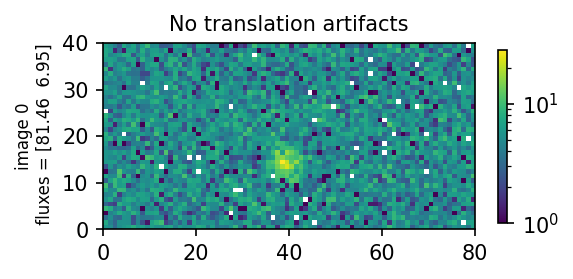

In [56]:
# simple plot for sanity
plt.gcf().set_size_inches(4,3)
plt.pcolormesh(imgs[0],norm='log',vmin=1)
plt.ylabel(f"image {0}\n fluxes = {cat.source_fluxes[0].cpu().numpy().round(2)}", fontsize=8)
plt.colorbar(shrink=0.5)
plt.title(f"No translation artifacts", fontsize=10)
plt.gca().set_aspect('equal')
plt.show()

## Bad Column Testing

One possible artifact in exposure images is when a particular column of pixels consistently fail. Input images to a coadd may not necessarily use the same CCD detector, and as such the bad column may change from image to image, or lack a column entirely. Bad columns are usually handled with interpolation algorithms, and are then typically masked as interpolated. 

Current requirements:
- Have the column be choosen randomly from 0 to the max image width
- Choose a pixel randomly between 0 and the max image height, and choose a random length (cut off if it reaches an edge)
    - A more simple alternative: choose a column and use the entire height
- Set pixel values to 0 (later `nan`)
    - This should be done prior to offsets since this is a CCD artifact
    - Likely add after fluxes/noise have been added to avoid being overwritten with fluxes.
- "Masked" (nan) pixels are simply not added to coadd.
    - May update if adding weights to the pixels (based on a variance plane) becomes an option.
    - A "cheaper" option may be to simply fill the masked pixels with the median flux

**Note**: Simply ignoring `nan` pixels by pretending they have 0 flux is not realistic for the long term. This will cause issues since there will be a slight streak of pixels with lower flux, especially when `coadd_depth` is only set to 5. Ideally, the pixels should be interpolated over (using interpolator of choice), generate a new variance plane with the interpolated pixels (in LSST land, these are currently included when calculating the image weight), then weight the entire image using the variance plane prior to coadding.

In [57]:
# define the model for the coadd simulation with 
bad_column_image_model = imagesampler.ImageSampler(
    coadd_depth=5,
    height = 40,
    width = 80,
    translation_artifacts=False,
    bad_column_artifacts=True,
)

In [58]:
column_imgs=bad_column_image_model.sample_images(cat,rng).cpu().numpy()

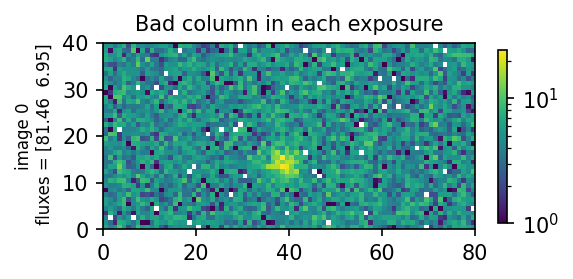

In [61]:
# simple plot for sanity
plt.gcf().set_size_inches(4,3)
plt.pcolormesh(column_imgs[0],norm='log',vmin=1)
plt.ylabel(f"image {0}\n fluxes = {cat.source_fluxes[0].cpu().numpy().round(2)}", fontsize=8)
plt.colorbar(shrink=0.5)
plt.title(f"Bad column in each exposure", fontsize=10)
plt.gca().set_aspect('equal')
plt.show()